# Import Library used in project

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# tokenize the document
from keras.preprocessing.text import text_to_word_sequence
# This must be list of strings
from keras.preprocessing.text import Tokenizer  
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.layers import Input, concatenate, Embedding, LSTM, GRU, Dense, Dropout, Flatten, Conv1D, BatchNormalization, MaxPooling1D
from tensorflow.keras.utils import plot_model
from keras.models import load_model

from gensim.models import Word2Vec
from gensim.corpora.dictionary import Dictionary
from collections import Counter
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')
#to fix imbalance in data 
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# the dimension of word vector
vocab_dim = 256
# sentence length
maxlen = 150
# batch size
batch_size = 512
# epoch num
n_epoch = 30
# input length
input_length = 150

In [6]:
df = pd.read_csv('tweet_emotions.csv', on_bad_lines='skip')

In [7]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [8]:
df.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5208
sadness       5165
love          3842
surprise      2186
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [9]:
df = df[df['sentiment'].isin(['neutral','happiness','sadness','anger'])]

In [10]:
df.sentiment.value_counts()

neutral      8638
happiness    5208
sadness      5165
anger         110
Name: sentiment, dtype: int64

In [11]:
df.drop('tweet_id',axis=1,inplace=True)

In [13]:
df

,sentiment,content
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
4,neutral,@dannycastillo We want to trade with someone w...
6,sadness,"I should be sleep, but im not! thinking about ..."
8,sadness,@charviray Charlene my love. I miss you
...,...,...
39990,neutral,@jasimmo Ooo showing of your French skills!! l...
39991,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
39992,happiness,Succesfully following Tayla!!
39993,neutral,@JohnLloydTaylor


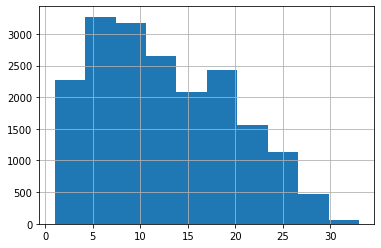

In [15]:
# Create a column containing the length of all words for each row
df['lenght'] = df.content.apply(lambda x: len(x.split()))
df['lenght'].hist()

In [16]:
def get_longest_text(texts):
    longest_input = 0
    for text in texts:
        text_len= len(text.split())
        longest_input = max(longest_input, text_len)
    return longest_input
longest_input = get_longest_text(df['content'])
longest_input

33

# **Data preprocessing**

In [17]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))

#remove_repeating_char
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

#processPost for applying all functions
def processPost(text): 
    #Replace @username with empty string
    text = re.sub('@[^\s]+', ' ', text)
    #Convert www.* or https?://* to " "
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    #Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)    
    return text
    
def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

# convert each word to lower case
def to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# replace all numbers with ''
def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)

# remove spaces from right and left sentences
def remove_whitespaces(text):
    return text.strip()

# remove stop words like the he she it for 
def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]

# return root of each word
def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

# return root of each word if word is Noun
def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

# return root of each word if word is Verb
def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

# split each sentence based on some features
def text2words(text):
    return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

In [20]:
# create column contain clean code
df['clean_content'] = df.content.apply(lambda x: normalize_text(x))

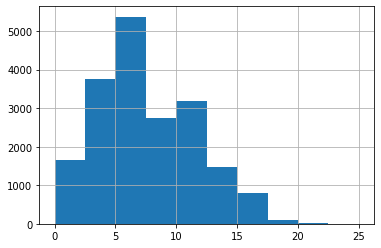

In [21]:
# Create a column containing the length of all words for each row
df['clean_lenght'] = df['clean_content'].apply(lambda x: len(x.split()))
df['clean_lenght'].hist()

In [22]:
def get_longest_text(texts):
    longest_input = 0
    for text in texts:
        text_len= len(text.split())
        longest_input = max(longest_input, text_len)
    return longest_input
longest_input = get_longest_text(df['clean_content'])
longest_input

25

In [23]:
df.head()

,sentiment,content,lenght,clean_Review,clean_content,clean_lenght
1,sadness,Layin n bed with a headache ughhhh...waitin o...,10,layin n bed headache ughhhhwaitin call,layin n bed headache ughhhhwaitin call,6
2,sadness,Funeral ceremony...gloomy friday...,3,funeral ceremonygloomy friday,funeral ceremonygloomy friday,3
4,neutral,@dannycastillo We want to trade with someone w...,15,dannycastillo want trade someone houston ticke...,dannycastillo want trade someone houston ticke...,7
6,sadness,"I should be sleep, but im not! thinking about ...",26,sleep im think old friend want he marry damn w...,sleep im think old friend want he marry damn w...,11
8,sadness,@charviray Charlene my love. I miss you,7,charviray charlene love miss,charviray charlene love miss,4


In [26]:
# show any row after apply clean sentences
df.clean_content.iloc[np.random.randint(0,5000)]

'booya sup tweeps happy infamous day get soon cant wait play need find time though'

In [27]:
# create list sentences contain list of list of words [[],[],[]]
sentences = [i.split() for i in df.clean_content]

In [28]:
words = [word for text in sentences for word in text]

In [29]:
# show most repeated word in text
from collections import Counter
word_counts = Counter(words)
word_counts.most_common(10)

[('get', 2053),
 ('im', 1976),
 ('go', 1906),
 ('day', 1572),
 ('good', 1106),
 ('work', 1081),
 ('like', 916),
 ('today', 819),
 ('u', 745),
 ('miss', 735)]

# **Word Embedding - Word2vec**

In [30]:
# create word 2 vec model to train on custom dataset
model = Word2Vec(sentences=sentences,size=vocab_dim, min_count=1, workers=6,iter=10)

In [31]:
model.train(sentences, total_examples=model.corpus_count, epochs=50)

(6463838, 7040150)

In [32]:
#show keys in text
# model.wv.vocab.keys()

In [33]:
# create one for each word in model 
gensim_dict = Dictionary()
gensim_dict.doc2bow(model.wv.vocab.keys(),allow_update=True)

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 1),
 (99, 1),
 (100, 1),

In [34]:
# create Dictionary contain each word and index +1 for unknown value 
w2indx = {v: k + 1 for k, v in gensim_dict.items()}

In [35]:
# w2indx.keys()

In [36]:
# create Dictionary contain each word and vector from model 
w2vec = {word: model[word] for word in w2indx.keys()}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [37]:
# create data contain if word in model put index of it else put zero
data = []
for sentence in sentences:
    new_txt = []
    for word in sentence:
        try:
            new_txt.append(w2indx[word])
        except:
            new_txt.append(0)
    data.append(new_txt)


In [38]:
# pad 0 for all row in data matrix with maxlength to fix shape of all rows
matrix_data = pad_sequences(data,maxlen=maxlen,padding='post')

In [39]:
# create weight for embedding layer
n_symbols = len(w2indx) +1
embedding_weights = np.zeros((n_symbols,vocab_dim))
for word, index in w2indx.items():
    embedding_weights[index,:] = w2vec[word]

# **split data**

In [42]:
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df.sentiment)

In [43]:
x_train, x_validate, y_train, y_validate = train_test_split(matrix_data, y_encoded, test_size=0.2, random_state=42, stratify=df.sentiment)

# **Build Models**


In [46]:
class_len = len(df.sentiment.unique())

In [69]:
# Convolution
kernel_size = 5
filters = 64
pool_size = 4
model = Sequential()
model.add(Embedding(input_dim=n_symbols,input_length=input_length,mask_zero=True,weights=[embedding_weights],trainable=False,output_dim=vocab_dim))#No masking allowed for Conv1D
model.add(Dropout(0.2))
model.add(Conv1D(filters,kernel_size,padding='same',activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
# model.add(Conv1D(filters,kernel_size,padding='valid',activation='relu',strides=1))
# model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(8))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(class_len,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 256)          6853376   
                                                                 
 dropout_10 (Dropout)        (None, 150, 256)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 150, 64)           81984     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 37, 64)           0         
 1D)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 8)                 2336      
                                                                 
 batch_normalization_5 (Batc  (None, 8)                32        
 hNormalization)                                      

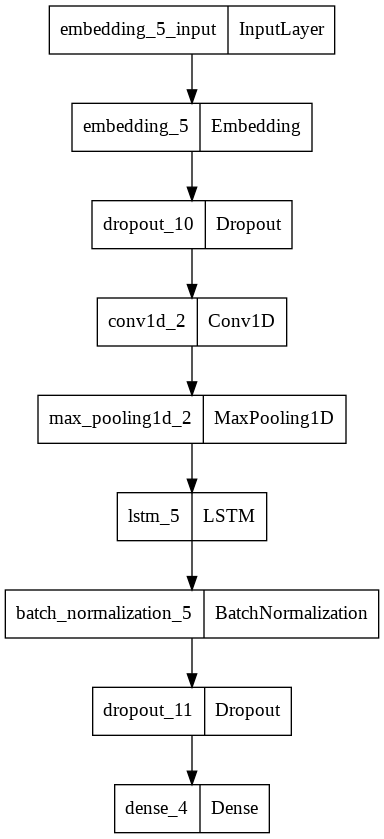

In [70]:
plot_model(model)

In [71]:
# #early stop to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
# #save best models in training
# chkpt = ModelCheckpoint("./model.h5", monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True, mode='max')
# #reduce learing rate each 5 epoch
ReduceLR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,patience=10, min_lr=0.001)
# #combine all callbacks
callbacks = [early_stopping, ReduceLR]

In [72]:
# train model
history = model.fit(matrix_data, y_encoded,validation_split=.15,epochs=n_epoch,batch_size=batch_size,verbose=1,callbacks=callbacks)#

Epoch 1/30
32/32 [==============================] - 5s 79ms/step - loss: 1.3076 - accuracy: 0.4113 - val_loss: 1.3489 - val_accuracy: 0.4705 - lr: 0.0010
Epoch 2/30
32/32 [==============================] - 2s 60ms/step - loss: 1.2152 - accuracy: 0.4911 - val_loss: 1.3099 - val_accuracy: 0.4709 - lr: 0.0010
Epoch 3/30
32/32 [==============================] - 2s 60ms/step - loss: 1.1456 - accuracy: 0.5481 - val_loss: 1.2639 - val_accuracy: 0.4705 - lr: 0.0010
Epoch 4/30
32/32 [==============================] - 2s 60ms/step - loss: 1.0796 - accuracy: 0.5869 - val_loss: 1.2051 - val_accuracy: 0.4705 - lr: 0.0010
Epoch 5/30
32/32 [==============================] - 2s 60ms/step - loss: 1.0173 - accuracy: 0.6070 - val_loss: 1.1499 - val_accuracy: 0.4705 - lr: 0.0010
Epoch 6/30
32/32 [==============================] - 2s 60ms/step - loss: 0.9711 - accuracy: 0.6175 - val_loss: 1.1377 - val_accuracy: 0.4705 - lr: 0.0010
Epoch 7/30
32/32 [==============================] - 2s 61ms/step - loss: 0.9

# **Performance evaluation**

In [73]:
loss, accuracy = model.evaluate(x_validate,y_validate,batch_size=512)
print('Accuracy: %f' % (accuracy*100))

8/8 [==============================] - 0s 18ms/step - loss: 1.2989 - accuracy: 0.4641
Accuracy: 46.405229


# **show classification report and confusion matrix**

In [74]:
out = model.predict(x_validate)#predict on validation data
model_y_pred = np.argmax(out,axis=1)

In [78]:
df.sentiment.unique()

array(['sadness', 'neutral', 'happiness', 'anger'], dtype=object)

In [81]:
df.sentiment.value_counts()

neutral      8638
happiness    5208
sadness      5165
anger         110
Name: sentiment, dtype: int64

In [79]:
def show_report_con(y_pred):
    print(classification_report(y_validate,y_pred))
    label = ['sadness', 'neutral', 'happiness', 'anger']
    cm = confusion_matrix(y_validate,y_pred,normalize='true')
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.xaxis.set_ticklabels(label)
    ax.yaxis.set_ticklabels(label)
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00      1042
           2       0.46      0.99      0.63      1728
           3       0.84      0.06      0.11      1033

    accuracy                           0.46      3825
   macro avg       0.32      0.26      0.18      3825
weighted avg       0.43      0.46      0.31      3825



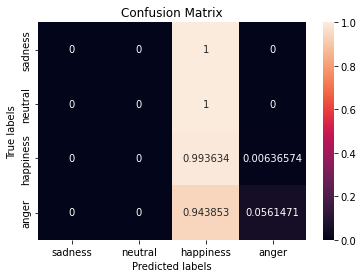

In [80]:
show_report_con(model_y_pred)

# **Plot accuracy**

In [82]:
# summarize history for acc
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

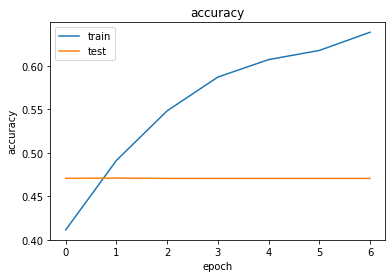

In [83]:
plot_acc(history)

# **Plot losses**

In [84]:
# summarize history for loss
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

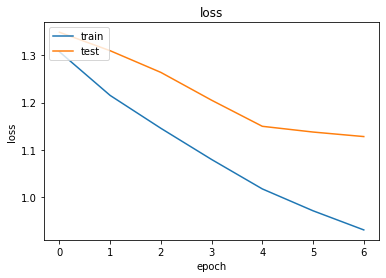

In [85]:
plot_loss(history)

In [86]:
def print_acc_pre_rec_f1(y_pred):
    # accuracy: (tp + tn) / (p + n)
    model_accuracy = accuracy_score(y_validate, y_pred)
    print(model_accuracy)
    # precision tp / (tp + fp)
    model_precision = precision_score(y_validate, y_pred,average='macro')
    print(model_precision)
    # recall: tp / (tp + fn)
    model_recall = recall_score(y_validate, y_pred,average='macro')
    print(model_recall)
    # f1: 2 tp / (2 tp + fp + fn)
    model_f1 = f1_score(y_validate, y_pred,average='macro')
    print(model_f1)

In [87]:
print_acc_pre_rec_f1(model_y_pred)

0.46405228758169936
0.32442874010279205
0.26244535087483417
0.1828621060309417


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
